# Save for Xmas - Post Scoring
## Model 2020-07-23

In [1]:
import sys
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, './helper')
sys.path.insert(0, '/home/jovyan/a01_repos/wx_tools')
sys.path.insert(0, '/home/jovyan/a01_repos/joe_utils')

import sfx_config as cfg
import wx_utils as utl
import wx_visualise as viz
import UDF_Validation as vld
import UDF_Visualisation as viz2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
importlib.reload(sys.modules['wx_utils'])
importlib.reload(sys.modules['sfx_config'])

<module 'wx_utils' from '/home/jovyan/a01_repos/wx_tools/wx_utils.py'>

<module 'sfx_config' from './helper/sfx_config.py'>

## Paths

In [27]:
path_local_scored = f'{cfg.PATH_LOCAL_DATA}/scored_20200723.parquet'

In [6]:
# Test set
path_gcp_test = f'{cfg.PATH_GCP_MODELS}/propensity/2020-07-23/scoring/scored_T.parquet'
path_local_test = f'{cfg.PATH_LOCAL_DATA}/test_20200723.parquet'
# utl.copy_gsutil(path_gcp_test, path_local_test)

0


## Validate Test Set

In [7]:
test0 = pd.read_parquet(path_local_test)
test0.shape
test0.head(2)

(227536, 107)

crn      ref_dt  target  sample_weight  f0_age  \
6   1000000000001403792  2020-06-28     0.0       4.994529    48.0   
21  1100000000049725160  2020-06-28     0.0       4.994529    38.0   

    f0_all_loc__kmart_walktime  f0_bigw_txn_flx_104wk__avg_weekly_spend_amt  \
6                   242.729996                                     4.978715   
21                   58.779999                                     0.000000   

    f0_bigw_txn_flx_16wk__avg_weekly_spend_amt f0_affluence  f0_age_band  \
6                                     2.784091   3. premium  6. [45, 55)   
21                                    0.000000    1. budget  5. [35, 45)   

   f01_grouparea_code f01_liquor_lcns_flag f01_mem_gender  \
6                  13                    n              f   
21               none                 none              m   

   f01_mem_marital_status_flag f01_mem_mobile_no_flag f01_mem_segment_bpm_now  \
6                            n                      y                 premium   
21                           n                      y                  budget   

   f01_mem_segment_cell_current f01_mem_segment_cell_previous  \
6                       mvhfmas                       mvhfmbs   
21                     inactive                                 

   f01_mem_status_desc f01_store_cluster_desc f07_card_number_total  \
6    everyday customer   budget one stop shop                   1.0   
21   everyday customer                   none                   1.0   

   f21_num_comp_within_5km f23_ncp_camp_redeem_times_8w f27_email_mp_8w  \
6                      1.0                          nan    apple mail 1   
21                    10.0                          nan     unspecified   

     f27_os_mp_8w        f0_lifestage f0_macro_segment_curr  \
6   mac os x 10.1  06. older families            08. mvmeda   
21    unspecified                none          02. inactive   

   f0_macro_segment_prev f0_postcode f0_tenure_band  \
6                 mvmedb       other        6. > 10   
21                             other     5. (5, 10]   

    f0_bigw_txn_flx_52wk__avg_weekly_spend_amt  \
6                                     6.835664   
21                                    0.000000   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_9550057  \
6                                                 0.0   
21                                                0.0   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_9550103  \
6                                                 0.0   
21                                                0.0   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_9550154  \
6                                            3.327221   
21                                           0.000000   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_9550160  \
6                                                 0.0   
21                                                0.0   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_9550169  \
6                                           -0.000029   
21                                           0.000000   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_9550172  \
6                                                 0.0   
21                                                0.0   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_9570120  \
6                                            0.000186   
21                                           0.000000   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_9570315  \
6                                                 0.0   
21                                                0.0   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_9810725  \
6                                                 0.0   
21                                                0.0   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_9815621  \
6                                            0.000107   
21                                           0.000000   

    f0_bigw_txn_flx_52wk__spend_pct_idx_ctgry_98902

In [8]:
cols = ['crn', 'pred', 'target', 'sample_weight']
test = test0[cols]
test['target_wgtd'] = test['target'] * test['sample_weight']
test.describe().T

/home/jovyan/my-conda-envs/melon/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



count      mean       std       min       25%       50%  \
pred           227536.0  0.102187  0.285467  0.000003  0.000560  0.001702   
target         227536.0  0.122785  0.328191  0.000000  0.000000  0.000000   
sample_weight  227536.0  4.504061  1.310968  1.000000  4.994529  4.994529   
target_wgtd    227536.0  0.122785  0.328191  0.000000  0.000000  0.000000   

                    75%       max  
pred           0.007184  1.000000  
target         0.000000  1.000000  
sample_weight  4.994529  4.994529  
target_wgtd    0.000000  1.000000

In [9]:
# Sort by prediction
test = (
    test.sort_values(by='pred', ascending=False)
    .reset_index(drop=True)
)

In [10]:
# Aggregate
quantum_pct = 0.01
test_agg, q_vol, q_pct, _ = utl.aggregate_metrics(
    test, ['target', 'pred'], quantum_pct,
)

In [11]:
# Aggregate: target weighted average
test_agg_sum = utl.aggregate_metrics(
    test, ['target_wgtd', 'sample_weight'], quantum_pct,
    stat='sum'
)[0]
test_agg_sum['target_wgtd_avg'] = test_agg_sum['target_wgtd'] / test_agg_sum['sample_weight']

In [12]:
test_agg = test_agg.merge(test_agg_sum['target_wgtd_avg'], left_index=True, right_index=True)

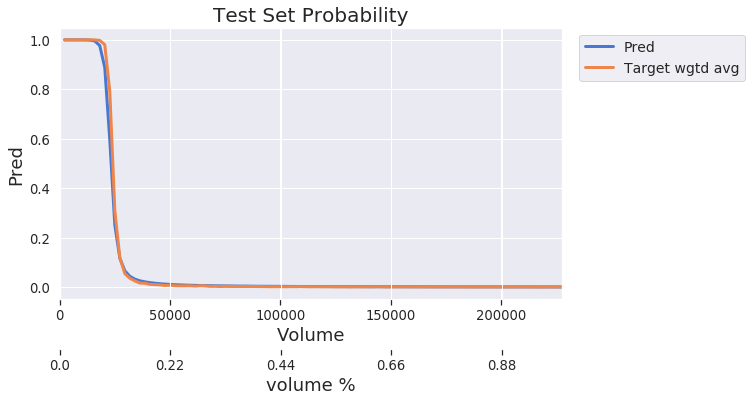

In [13]:
f, ax = viz.plot_multi_metrics(
    test_agg, x='volume', metrics=['pred', 'target_wgtd_avg'],
    title='Test Set Probability'
)
viz.plot_x_volume_to_percent(ax, q_vol, q_pct)

### View top predictions

In [24]:
test.head()

crn  pred  target  sample_weight  target_wgtd
0  1100000000065149221   1.0     1.0            1.0          1.0
1  1100000000000938373   1.0     1.0            1.0          1.0
2  1000000000002788730   1.0     1.0            1.0          1.0
3  1100000000004994510   1.0     1.0            1.0          1.0
4  1100000000052834647   1.0     1.0            1.0          1.0

In [26]:
test0.sort_values(by='pred', ascending=False, inplace=True)
test0.head()

crn      ref_dt  target  sample_weight  f0_age  \
1073041  1100000000065149221  2020-05-24     1.0            1.0    44.0   
903365   1100000000000938373  2020-06-14     1.0            1.0    38.0   
804407   1000000000002788730  2020-05-10     1.0            1.0    38.0   
758857   1100000000004994510  2020-06-14     1.0            1.0    48.0   
162660   1100000000052834647  2020-06-21     1.0            1.0    39.0   

         f0_all_loc__kmart_walktime  \
1073041                   54.279999   
903365                    73.900002   
804407                     0.000000   
758857                   836.080017   
162660                    39.130001   

         f0_bigw_txn_flx_104wk__avg_weekly_spend_amt  \
1073041                                    41.139565   
903365                                     66.011711   
804407                                    102.890221   
758857                                     70.444931   
162660                                     23.086975   

         f0_bigw_txn_flx_16wk__avg_weekly_spend_amt f0_affluence  f0_age_band  \
1073041                                  117.201706    1. budget  5. [35, 45)   
903365                                   130.039490    1. budget  5. [35, 45)   
804407                                   185.170456    1. budget  5. [35, 45)   
758857                                    64.081535    1. budget  6. [45, 55)   
162660                                    25.417614   3. premium  5. [35, 45)   

        f01_grouparea_code f01_liquor_lcns_flag f01_mem_gender  \
1073041              other                    n              f   
903365                  07                    n              f   
804407                  14                    n              f   
758857                  12                    n              f   
162660               other                    n              f   

        f01_mem_marital_status_flag f01_mem_mobile_no_flag  \
1073041                           n                      y   
903365                            n                      y   
804407                            n                      y   
758857                            n                      y   
162660                            n                      y   

        f01_mem_segment_bpm_now f01_mem_segment_cell_current  \
1073041                  budget                       hvhfhs   
903365                   budget                       hvhfhs   
804407                   budget                      hvhfmas   
758857                   budget                       hvhfhs   
162660                  premium                      hvhfmas   

        f01_mem_segment_cell_previous f01_mem_status_desc  \
1073041                       hvhfmas   everyday customer   
903365                                  everyday customer   
804407                                  everyday customer   
758857                        hvhfmas   everyday customer   
162660                        mvhfmas   everyday customer   

           f01_store_cluster_desc f07_card_number_total  \
1073041  mainstream one stop shop                   2.0   
903365       budget one stop shop                   1.0   
804407       budget one stop shop                   2.0   
758857       budget one stop shop                   1.0   
162660   mainstream one stop shop                   1.0   

        f21_num_comp_within_5km f23_ncp_camp_redeem_times_8w f27_email_mp_8w  \
1073041                     6.0                          nan         android   
903365                      5.0                          nan          iphone   
804407                      1.0                          nan          iphone   
758857                      3.0                          nan            none   
162660                    other                          nan     unspecified   

        f27_os_mp_8w        f0_lifestage f0_macro_segment_curr  \
1073041      android  06. older families            12. hvhigh   
903365           ios  04.

## Downsample Positive Class

In [14]:
test['sample_weight'].value_counts()
dsmpl_wgt = 1 / test['sample_weight'].max()
dsmpl_wgt

4.994529    199598
1.000000     27938
Name: sample_weight, dtype: int64

0.20021907971702638

In [15]:
cond = test['target'] == 1
pos_dsmpl = test[cond].sample(frac=dsmpl_wgt)
pos_dsmpl.shape

(5594, 5)

In [16]:
cond = test['target'] == 0
test_dsmpl = pd.concat((
    pos_dsmpl, test[cond]
))
test_dsmpl.shape

(205192, 5)

In [17]:
test_dsmpl.sort_values(by='pred', ascending=False, inplace=True)
test_dsmpl = test_dsmpl.reset_index(drop=True)

In [18]:
test_dsmpl.describe().T

count      mean       std       min       25%       50%  \
pred           205192.0  0.027441  0.141788  0.000003  0.000492  0.001386   
target         205192.0  0.027262  0.162847  0.000000  0.000000  0.000000   
sample_weight  205192.0  4.885629  0.650497  1.000000  4.994529  4.994529   
target_wgtd    205192.0  0.027262  0.162847  0.000000  0.000000  0.000000   

                    75%       max  
pred           0.004211  1.000000  
target         0.000000  1.000000  
sample_weight  4.994529  4.994529  
target_wgtd    0.000000  1.000000

Text(100000.0, 0.07, '0.0273')

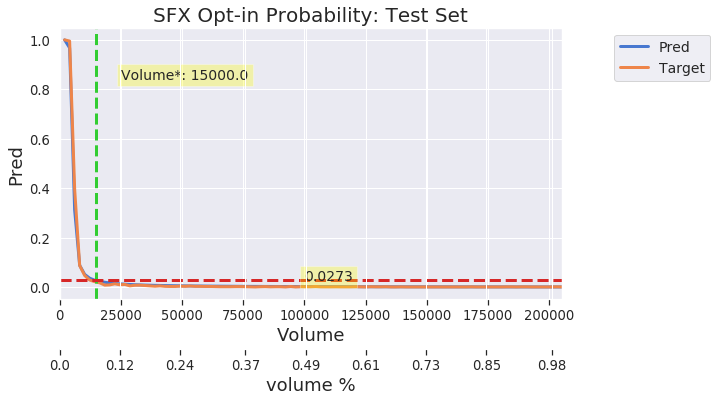

In [22]:
# Aggregate
quantum_pct = 0.01
dsmpl_agg, q_vol, q_pct, _ = utl.aggregate_metrics(
    test_dsmpl, ['target', 'pred'], quantum_pct,
)

f, ax = viz.plot_multi_metrics(
    dsmpl_agg, x='volume', metrics=['pred', 'target'],
    title='SFX Opt-in Probability: Test Set',
    x_opt=15e3
)
viz.plot_x_volume_to_percent(ax, q_vol, q_pct)

hline = test_dsmpl['target'].mean()
ax.axhline(y=hline, c='tab:red', ls='--', linewidth=3)
ax.text(
    x=100e3, y=0.07, s=np.round(hline,4),
    fontsize=14, verticalalignment='top',
    bbox=dict(facecolor='yellow', alpha=0.3)
)

Text(15000.0, 0.07, '0.0273')

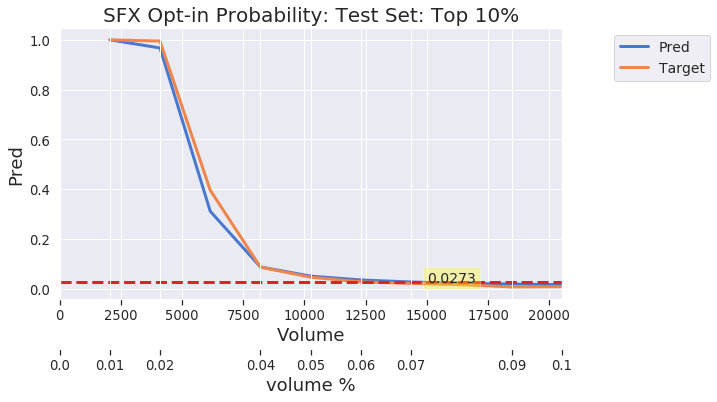

In [20]:
# Top 10%
cond = dsmpl_agg['volume_pct'] <= 0.1
x = dsmpl_agg[cond]

f, ax = viz.plot_multi_metrics(
    x, x='volume', metrics=['pred', 'target'],
    title='SFX Opt-in Probability: Test Set: Top 10%',
)
viz.plot_x_volume_to_percent(ax, q_vol, q_pct)

hline = test_dsmpl['target'].mean()
ax.axhline(y=hline, c='tab:red', ls='--', linewidth=3)
ax.text(
    x=15e3, y=0.07, s=np.round(hline,4),
    fontsize=14, verticalalignment='top',
    bbox=dict(facecolor='yellow', alpha=0.3)
)

In [21]:
dsmpl_agg.head(15)
# test_dsmpl.head(1000)['target'].mean()
# test_dsmpl.head(2055)['target'].mean()

volume               quantum    target      pred  volume_pct
0     2055     (-0.001, 2055.51]  0.486868  0.522653        0.01
1     4110    (2055.51, 4111.02]  0.208171  0.221161        0.02
2     6165    (4111.02, 6166.53]  0.141606  0.154539        0.03
3     8220    (6166.53, 8222.04]  0.131323  0.123837        0.04
4    10275   (8222.04, 10277.55]  0.106569  0.107318        0.05
5    12330  (10277.55, 12333.06]  0.097763  0.100223        0.06
6    14385  (12333.06, 14388.57]  0.102190  0.091033        0.07
7    16440  (14388.57, 16444.08]  0.085603  0.081883        0.08
8    18495  (16444.08, 18499.59]  0.078345  0.074533        0.09
9    20550   (18499.59, 20555.1]  0.068580  0.068512        0.10
10   22605   (20555.1, 22610.61]  0.052555  0.063028        0.11
11   24660  (22610.61, 24666.12]  0.059825  0.059664        0.12
12   26715  (24666.12, 26721.63]  0.052555  0.057010        0.13
13   28770  (26721.63, 28777.14]  0.057393  0.053781        0.14
14   30825  (28777.14, 30832.65]  0.051582  0.052409        0.15

## Scored Audience (to send)

In [28]:
scored = pd.read_parquet(path_local_scored)
scored.shape
scored.head(2)

(4666818, 13)

ref_dt                  crn macro_segment_curr      affluence  \
0  2020-07-19  1000000000000002034         09. MVMEDB      1. BUDGET   
1  2020-07-19  1000000000000003971          05. LVLFB  2. MAINSTREAM   

            lifestage spend_8wk gender  age     age_band  tenure tenure_band  \
0  06. OLDER FAMILIES     57.69      F   52  6. [45, 55)  4696.0     6. > 10   
1        07. RETIREES     32.53      M   69  8. [65, 75)  4681.0     6. > 10   

   wks_to_xmas     score  
0           21  0.147028  
1           21  0.235064

In [29]:
scored[['score']].describe().T

count     mean       std       min       25%       50%       75%  \
score  4666818.0  0.19015  0.242723  0.000082  0.017944  0.077433  0.269651   

            max  
score  0.999867

## Allocation

In [30]:
# Check known crns
crns = [
    '1100000000095370490', # Jen
    '1100000000002204029', # Winnie
    '3300000000002837429', # Joe
    '1000000000001705548', # Mum
]
cond = scored['crn'].isin(crns)
scored[cond]

ref_dt                  crn macro_segment_curr   affluence  \
12462  2020-07-19  1000000000001705548         12. HVHIGH  3. PREMIUM   
32698  2020-07-19  1100000000095370490         08. MVMEDA  3. PREMIUM   
35031  2020-07-19  3300000000002837429            03. LOW  3. PREMIUM   

                        lifestage spend_8wk gender  age     age_band  tenure  \
12462   03. OLDER SINGLES/COUPLES    152.09      F   62  7. [55, 65)  4422.0   
32698   01. YOUNG SINGLES/COUPLES     70.97      F   24  2. [20, 25)  2169.0   
35031  02. MIDAGE SINGLES/COUPLES      0.93      M   31  4. [30, 35)   246.0   

      tenure_band  wks_to_xmas     score  
12462     6. > 10           21  0.270868  
32698   4. (3, 5]           21  0.008785  
35031   1. [0, 1]           21  0.005817

## Set Random Group

In [31]:
# Random send audience volume
n_rand = 100e3

rand_grp = utl.select_random_group(
    scored, n_rand, random_state=cfg.RAND_SEED
)
rand_grp.shape

(100000, 13)

In [32]:
# Model-selection
model_grp = scored.merge(
    rand_grp['crn'],
    on='crn', how='left',
    indicator=True
)

cond = model_grp['_merge'] == 'left_only'
model_grp = model_grp[cond]
model_grp.drop(columns=['_merge'], inplace=True)

In [33]:
model_grp.shape

(4566818, 13)

### Lift

In [34]:
model_grp = (
    model_grp.sort_values(by='score', ascending=False)
    .reset_index(drop=True)
)

In [35]:
# Aggregate
quantum_pct = 0.01
agg, q_vol, q_pct, _ = utl.aggregate_metrics(
    model_grp, ['score'], quantum_pct,
)

Text(2000000.0, 0.07, '0.1902')

Text(1000000.0, 0.3, '1000000.0')

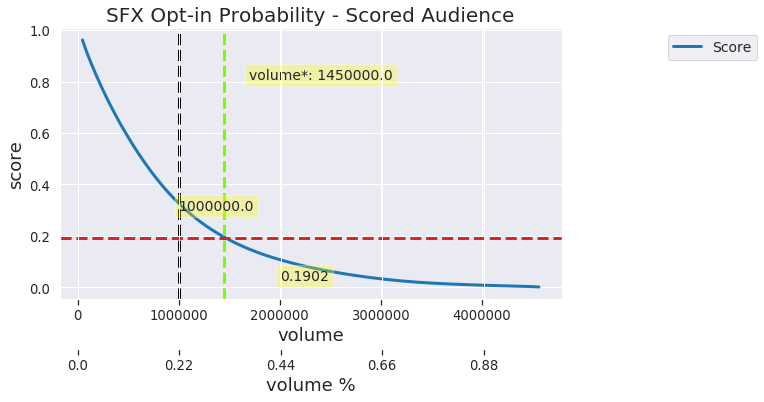

In [39]:
f, ax3, ax4 = viz.plot_dual_metrics(
    agg, x='volume', y1='score', y2=None,
    linewidth=3, title='SFX Opt-in Probability - Scored Audience',
    x_opt=1.45e6,
)
viz.plot_x_volume_to_percent(ax3, q_vol, q_pct)

hline = scored['score'].mean()
ax3.axhline(y=hline, c='tab:red', ls='--', linewidth=3)
ax3.text(
    x=2e6, y=0.07, s=np.round(hline,4),
    fontsize=14, verticalalignment='top',
    bbox=dict(facecolor='yellow', alpha=0.3)
)

# Cut-off
vline = 1e6
ax3.axvline(x=vline, c='black', ls='--', linewidth=3)
ax3.text(
    x=vline, y=0.3, s=vline,
    fontsize=14, horizontalalignment='left',
    bbox=dict(facecolor='yellow', alpha=0.3)
)

### Prediction Stats by Send Category

In [40]:
send_model = model_grp.head(np.int(vline))
send_model['send_catg'] = 'M'
rand_grp['send_catg'] = 'R'

send = pd.concat((send_model, rand_grp))
send.shape

/home/jovyan/my-conda-envs/melon/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1100000, 14)

In [41]:
send.groupby('send_catg').agg({
    'crn': 'count',
    'score': 'mean',
})

crn     score
send_catg                   
M          1000000  0.594452
R           100000  0.189260

In [42]:
send.head(2)

ref_dt                  crn macro_segment_curr      affluence  \
0  2020-07-19  1100000000140955262         12. HVHIGH      1. BUDGET   
1  2020-07-19  1100000000103567331         12. HVHIGH  2. MAINSTREAM   

                   lifestage spend_8wk gender  age     age_band  tenure  \
0         04. YOUNG FAMILIES    546.78      F   31  4. [30, 35)   888.0   
1  01. YOUNG SINGLES/COUPLES    672.83      M   22  2. [20, 25)  1936.0   

  tenure_band  wks_to_xmas     score send_catg  
0   2. (1, 2]           21  0.999867         M  
1   4. (3, 5]           21  0.999846         M

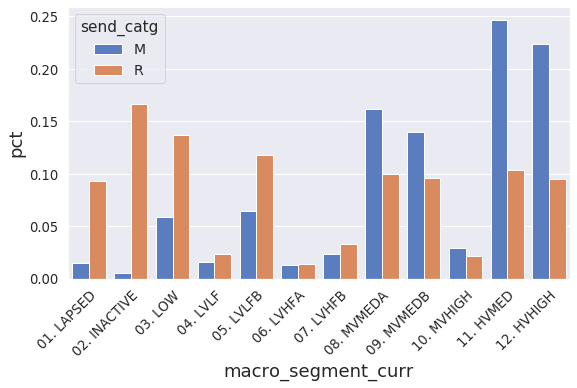

In [43]:
macro_segment_curr = utl.get_count_percent(send, ['send_catg', 'macro_segment_curr'], 'send_catg')
ax = sns.barplot(x='macro_segment_curr', y='pct', hue='send_catg', data=macro_segment_curr)
a = plt.setp(
    ax.get_xticklabels(), rotation=45, ha="right",
    rotation_mode="anchor"
)

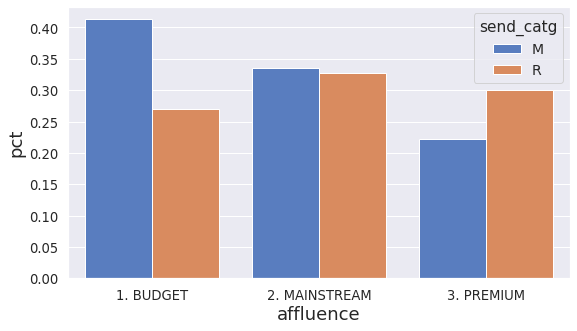

In [45]:
affluence = utl.get_count_percent(send, ['send_catg', 'affluence'], 'send_catg')
ax = sns.barplot(x='affluence', y='pct', hue='send_catg', data=affluence)

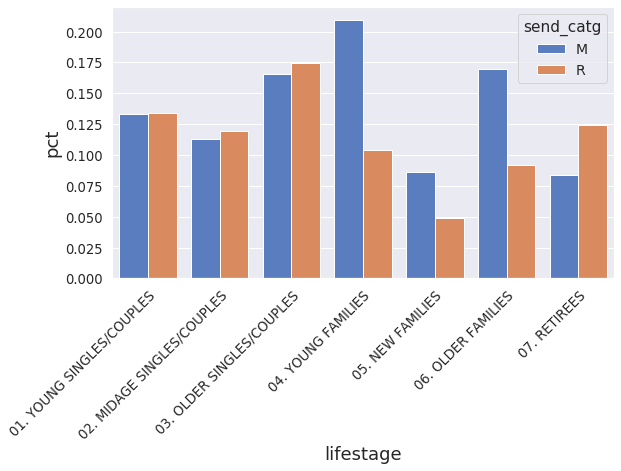

In [46]:
lifestage = utl.get_count_percent(send, ['send_catg', 'lifestage'], 'send_catg')
ax = sns.barplot(x='lifestage', y='pct', hue='send_catg', data=lifestage)
a = plt.setp(
    ax.get_xticklabels(), rotation=45, ha="right",
    rotation_mode="anchor"
)

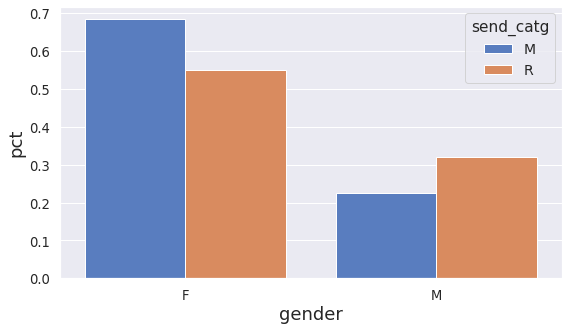

In [48]:
gender = utl.get_count_percent(send, ['send_catg', 'gender'], 'send_catg')
ax = sns.barplot(x='gender', y='pct', hue='send_catg', data=gender)